In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, mean_squared_error
import shap
import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
panel = pd.read_csv("../data/cleaned/feature_engineered_panel.csv")
print("Data shape:", panel.shape)
print("Columns:", panel.columns.tolist())

Data shape: (328890, 28)
Columns: ['fips', 'year', 'tot_clms', 'tot_opioid_clms', 'tot_prscrbrs', 'tot_opioid_prscrbrs', 'opioid_prscrbng_rate', 'state', 'county', 'pct_uninsured', 'pct_unemployed', 'pct_children_in_poverty', 'income_ratio', 'mental_health_provider_rate', 'primary_care_physicians_rate', 'pct_adults_reporting_currently_smoking', 'pct_adults_with_obesity', 'pct_excessive_drinking', 'pct_severe_housing_problems', 'injury_death_rate', 'opioid_claims_share', 'cost_per_claim', 'claims_per_1k', 'log1p_claims_per_1k', 'population', 'opioid_cost', 'opioid_cost_per_capita', 'log1p_cost_per_claim']


In [4]:
from sklearn.metrics import mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    """Version-proof RMSE (works with any sklearn version)."""
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

In [5]:
# Target: opioid cost per capita (we’ll compute if not present)
if "opioid_cost_per_capita" not in panel.columns:
    if "tot_opioid_clms" in panel.columns and "population" in panel.columns:
        panel["opioid_cost_per_capita"] = (
            panel["cost_per_claim"].fillna(0) * panel["tot_opioid_clms"].fillna(0)
        ) / (panel["population"].replace(0, np.nan))
    else:
        raise ValueError("Required columns not found for cost_per_capita calculation.")

# Drop rows with missing target
panel = panel.dropna(subset=["opioid_cost_per_capita"])
print("After dropping NaN target:", panel.shape)

After dropping NaN target: (112855, 28)


In [6]:
# Target: opioid cost per capita (we’ll compute if not present)
if "opioid_cost_per_capita" not in panel.columns:
    if "tot_opioid_clms" in panel.columns and "population" in panel.columns:
        panel["opioid_cost_per_capita"] = (
            panel["cost_per_claim"].fillna(0) * panel["tot_opioid_clms"].fillna(0)
        ) / (panel["population"].replace(0, np.nan))
    else:
        raise ValueError("Required columns not found for cost_per_capita calculation.")

# Drop rows with missing target
panel = panel.dropna(subset=["opioid_cost_per_capita"])
print("After dropping NaN target:", panel.shape)

After dropping NaN target: (112855, 28)


In [7]:
print("NaN count in opioid_cost_per_capita:", panel["opioid_cost_per_capita"].isna().sum())
print("Any NaN in y after dropping?", panel["opioid_cost_per_capita"].isna().any())

NaN count in opioid_cost_per_capita: 0
Any NaN in y after dropping? False


In [8]:
# --- STEP 4. Automated feature selection setup ---
# Use all numeric variables (excluding IDs, target, and year)
numeric_cols = panel.select_dtypes(include=[np.number]).columns.tolist()
drop_cols = ["year", "opioid_cost_per_capita"]
feature_candidates = [c for c in numeric_cols if c not in drop_cols]

print(f"Candidate numeric features: {len(feature_candidates)}")

X = panel[feature_candidates]
y = panel["opioid_cost_per_capita"]

Candidate numeric features: 23


In [9]:

# --- STEP 5. Variance Threshold — remove near-constant columns ---
var_thresh = VarianceThreshold(threshold=0.0)
var_thresh.fit(X)
X_reduced = X.loc[:, var_thresh.get_support()]

print(f"Features after variance threshold: {X_reduced.shape[1]}")

Features after variance threshold: 23


In [10]:

# --- STEP 6. Correlation-based feature pruning ---
corr_matrix = X_reduced.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
X_selected = X_reduced.drop(columns=to_drop, errors='ignore')

print(f"Features after removing highly correlated (>0.9) columns: {X_selected.shape[1]}")


Features after removing highly correlated (>0.9) columns: 18


In [32]:
X_selected.columns.tolist()

['tot_clms',
 'opioid_prscrbng_rate',
 'pct_uninsured',
 'pct_unemployed',
 'pct_children_in_poverty',
 'income_ratio',
 'mental_health_provider_rate',
 'primary_care_physicians_rate',
 'pct_adults_reporting_currently_smoking',
 'pct_adults_with_obesity',
 'pct_excessive_drinking',
 'pct_severe_housing_problems',
 'injury_death_rate',
 'cost_per_claim',
 'claims_per_1k',
 'log1p_claims_per_1k',
 'population',
 'opioid_cost']

In [30]:
X_selected.columns.tolist()

['tot_clms',
 'opioid_prscrbng_rate',
 'pct_uninsured',
 'pct_unemployed',
 'pct_children_in_poverty',
 'income_ratio',
 'mental_health_provider_rate',
 'primary_care_physicians_rate',
 'pct_adults_reporting_currently_smoking',
 'pct_adults_with_obesity',
 'pct_excessive_drinking',
 'pct_severe_housing_problems',
 'injury_death_rate',
 'cost_per_claim',
 'claims_per_1k',
 'log1p_claims_per_1k',
 'population',
 'opioid_cost']

In [15]:
# --- STEP 7. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=42
)

In [16]:
# --- STEP 8. Model pipeline ---
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(random_state=42))
])

In [17]:
# --- STEP 9. Hyperparameter tuning ---
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [5, 10, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2"]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=15,
    scoring="r2",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("Best Model Parameters:", random_search.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; total time=  14.3s
[CV] END model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100; total time=   4.4s
[CV] END model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=  13.4s
[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=200; total time=  25.9s
[CV] END model__max_depth=20, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100; total time=  16.1s
[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=  29.8s
[

In [22]:
# --- STEP 10. Evaluate model ---
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"R² score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R² score: 0.9698
RMSE: 445.3578


In [19]:
residuals = y_test - y_pred
print(residuals.mean(), residuals.std())

0.3072406233159138 21.101576842171824


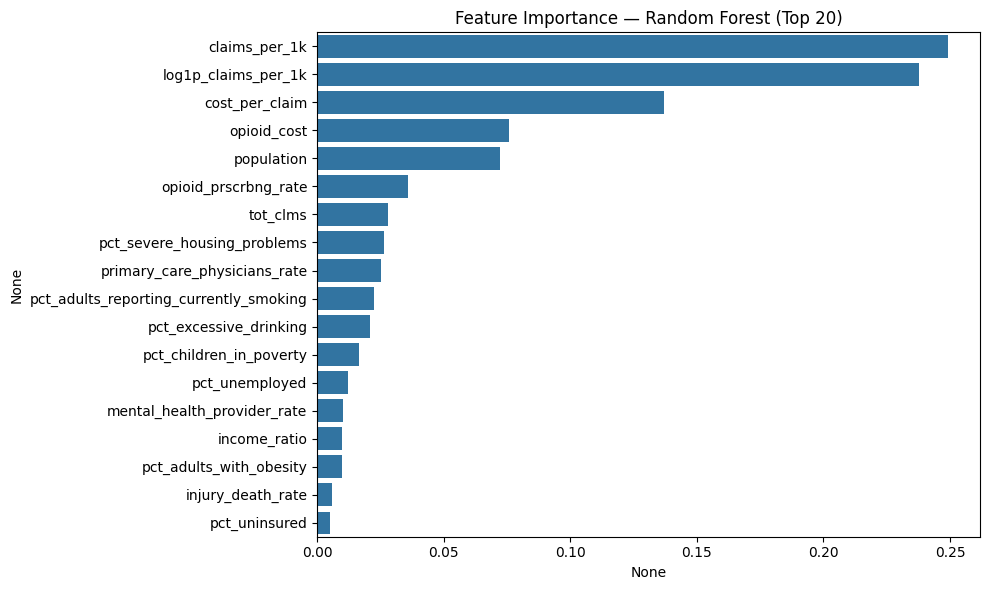

[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100; total time=  13.4s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100; total time=  12.9s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=300; total time=  41.5s
[CV] END model__max_depth=5, model__max_features=log2, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   5.2s
[CV] END model__max_depth=5, model__max_features=log2, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   5.2s
[CV] END model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   5.1s
[CV] END model__max_depth=20, model__max_features=log2, model__mi

In [20]:
# --- STEP 11. Feature Importance ---
model = best_model.named_steps["model"]
feat_imp = pd.Series(model.feature_importances_, index=X_selected.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp[:20], y=feat_imp.index[:20])
plt.title("Feature Importance — Random Forest (Top 20)")
plt.tight_layout()
plt.show()

In [13]:
drop_cols = ["year", "opioid_cost_per_capita"]    # target + non-predictive index fields
numeric_cols = panel.select_dtypes(include=[np.number]).columns.tolist()
feature_candidates = [c for c in numeric_cols if c not in drop_cols]
X = panel[feature_candidates]
y = panel["opioid_cost_per_capita"]

In [34]:
import joblib, json, time, os
os.makedirs("../data", exist_ok=True)
os.makedirs("../data/results", exist_ok=True)

y_pred = best_model.predict(X_test)
final_r2   = r2_score(y_test, y_pred)
final_rmse = mean_squared_error(y_test, y_pred)


print("FINAL hold-out R²:", final_r2)
print(f"FINAL hold-out RMSE ($): {final_rmse:.4f}")

# Save pipeline (imputer + scaler + RF all together)
joblib.dump(best_model, "../models/final_model.pkl")

# Save metadata for reproducibility
meta = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "random_state": 42,
    "split": {"test_size": 0.30},
    "final_holdout_r2": final_r2,
    "final_holdout_rmse": final_rmse,
    "features": feature_candidates,
    "best_params": best_model.named_steps["model"].get_params()
}
with open("../models/final_model_meta.json", "w") as f:
    json.dump(meta, f, indent=2)


FINAL hold-out R²: 0.9698221818455887
FINAL hold-out RMSE ($): 445.3578


In [25]:
# --- STEP 6B. Save final feature list for reproducibility ---
import json, os
os.makedirs("../data", exist_ok=True)

final_features = X_selected.columns.tolist()
with open("../models/final_feature_list.json", "w") as f:
    json.dump(final_features, f, indent=2)

print(f"Saved final feature list ({len(final_features)} features)")


Saved final feature list (18 features)


In [33]:
os.makedirs("../data", exist_ok=True)

final_features = X_selected.columns.tolist()
with open("../models/final_feature_list.csv", "w") as f:
    json.dump(final_features, f, indent=2)

print(f"Saved final feature list ({len(final_features)} features)")


Saved final feature list (18 features)


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Copy data
X_temp = X.copy()
X_temp["log1p_cost_per_claim"] = np.log1p(X_temp["cost_per_claim"])
X_temp = X_temp.drop(columns=["cost_per_claim"])

r2_scores = cross_val_score(RandomForestRegressor(random_state=42),
                            X_temp, y, cv=3, scoring="r2")
print("Cross-validated R² (log cost_per_claim):", np.mean(r2_scores))


Cross-validated R² (log cost_per_claim): 0.9721970713328162


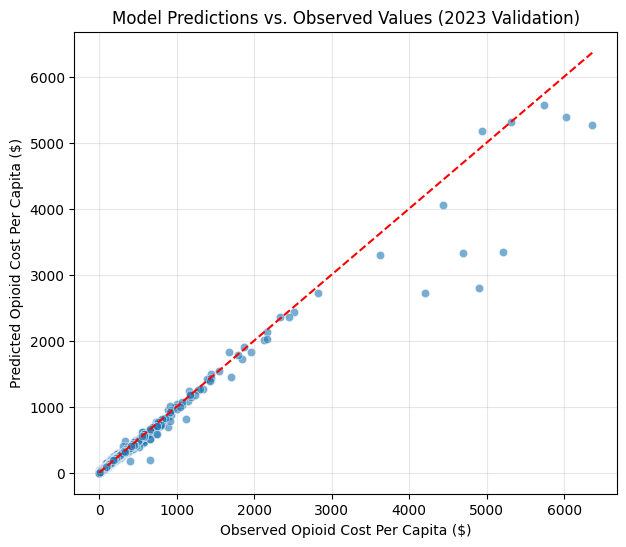

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.xlabel("Observed Opioid Cost Per Capita ($)")
plt.ylabel("Predicted Opioid Cost Per Capita ($)")
plt.title("Model Predictions vs. Observed Values (2023 Validation)")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# --- STEP 12. SHAP Interpretability ---
print("\nRunning SHAP interpretability...")

explainer = shap.TreeExplainer(model)
X_sample = best_model.named_steps["imputer"].transform(X_test)
X_sample = best_model.named_steps["scaler"].transform(X_sample)

shap_values = explainer.shap_values(X_sample)


Running SHAP interpretability...


In [1]:
# Global Summary
#shap.summary_plot(shap_values, X_sample, feature_names=X_selected.columns, show=False)
#plt.title("SHAP Summary — Global Feature Effects")
#plt.show()

In [2]:
# Mean Absolute SHAP
#shap.summary_plot(shap_values, X_sample, plot_type="bar", feature_names=X_selected.columns, show=False)
#plt.title("SHAP Mean Absolute Impact — Top Predictors of Opioid Cost per Capita")
#plt.show()

In [18]:
# --- STEP 13. SHAP Summary Table ---
shap_abs = np.abs(shap_values).mean(axis=0)
shap_summary = pd.DataFrame({
    "Feature": X_selected.columns,
    "MeanAbsSHAP": shap_abs
}).sort_values("MeanAbsSHAP", ascending=False)

print("\nTop 10 most influential features by SHAP:")
print(shap_summary.head(10))

shap_summary.to_csv("../data/results/shap_feature_importance_auto.csv", index=False)


NameError: name 'shap_values' is not defined

In [17]:
# --- STEP 14. Save model and performance summary ---
results = pd.DataFrame({
    "Model": ["RandomForestRegressor_AutoSelect"],
    "R2": [r2],
    "RMSE": [rmse]
})
results.to_csv("../data/results/model_performance_auto.csv", index=False)

print("\n Completed Notebook 06B — Automated Feature Selection + SHAP")


 Completed Notebook 06B — Automated Feature Selection + SHAP


In [21]:
results_df = pd.DataFrame({"Model": ["RandomForestRegressor"],
                           "R2": [r2],
                           "RMSE": [rmse]})
#results_df.to_csv("../data/results/model_performance_summary.csv", index=False)

In [20]:
results_df

,Model,R2,RMSE
0,RandomForestRegressor,0.969822,445.35779
